In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing
from scipy.stats import iqr
import tensorflow as tf

# Pre processing

In [2]:
path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=100000) # just read first 100000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    # cluster jets from the particles in one observation
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)): # for each jet get (px, py, pz, e)
        jet = []
        jet.append(jets[k].px)
        jet.append(jets[k].py)
        jet.append(jets[k].pz)
        jet.append(jets[k].e)
        # might be useful later for bump hunt
        jet.append(jets[k].pt)
        jet.append(jets[k].eta)
        jet.append(jets[k].phi)
        jet.append(jets[k].mass)
        data.append(jet)

In [7]:
loaded_data = data
# data = loaded_data

In [8]:
data = np.array(data)
data = data[:,:4]  # just keep px, py, pz, e
data.shape

(1477373, 4)

In [9]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [10]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [11]:
# get the inverse iqr proportion for each feature used to scale their weights in the loss function
iqr_prop = iqr(x_train,axis = 0)
max_iqr = max(iqr_prop)
iqr_prop = np.array(iqr_prop) / max_iqr
print(iqr_prop)

[0.03073949 0.0307984  0.38423165 1.        ]


# VAE Model

In [12]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape, LeakyReLU, ELU
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [13]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
inter_dim_1 = 32
inter_dim_2 = 16
final_dim = 8
latent_dim = 2
input_dim = 4

In [15]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
encoding = Dense(latent_dim, activation='tanh')(h3)

In [16]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(encoding)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [17]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [18]:
mse = keras.losses.MeanSquaredError()
def ae_loss(x, y):
    mse_loss = 0.25 * (iqr_prop[0]*(x[::,0] - y[::,0])**2 + iqr_prop[1]*(x[::,1] - y[::,1])**2 + iqr_prop[2]*(x[::,2] - y[::,2])**2 + iqr_prop[3]*(x[::,3] - y[::,3])**2)
    # mse_loss = mse(x,y)
    return mse_loss

vae.compile(optimizer='adam', loss=ae_loss)

In [19]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 16)                144     

# Train

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
batch_size = 1000
epochs = 200

In [22]:
x_train.shape

(1181898, 4)

In [23]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [24]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 1181898 samples, validate on 147737 samples
Epoch 1/200
1181898/1181898 [==============================] - 6s 5us/step - loss: 0.0492 - val_loss: 0.0159
Epoch 2/200
1181898/1181898 [==============================] - 5s 5us/step - loss: 0.0157 - val_loss: 0.0156
Epoch 3/200
1181898/1181898 [==============================] - 5s 5us/step - loss: 0.0155 - val_loss: 0.0155
Epoch 4/200
1181898/1181898 [==============================] - 5s 5us/step - loss: 0.0155 - val_loss: 0.0155
Epoch 5/200
1181898/1181898 [==============================] - 5s 5us/step - loss: 0.0155 - val_loss: 0.0155
Epoch 6/200
1181898/1181898 [==============================] - 5s 5us/step - loss: 0.0154 - val_loss: 0.0155
Epoch 7/200
1181898/1181898 [==============================] - 5s 5us/step - loss: 0.0154 - val_loss: 0.0155
Epoch 8/200
1181898/1181898 [==============================] - 5s 5us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 9/200
1181898/1181898 [==============================] - 5s 5us/step 

# Visualization

In [25]:
import matplotlib.pyplot as plt

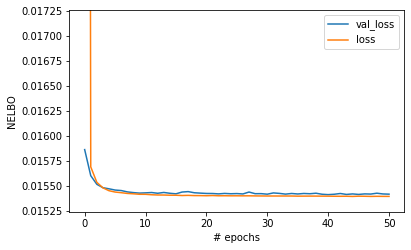

In [26]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [27]:
predictions = vae.predict(x_test)

In [28]:
# mse on test set
p = vae.predict(x_train)
print(mse(p, x_train))

tf.Tensor(0.500101, shape=(), dtype=float32)


In [29]:
distr = (x_test - predictions) / x_test

In [30]:
px_pred = [row[0] for row in predictions]
py_pred = [row[1] for row in predictions]
pz_pred = [row[2] for row in predictions]
e_pred = [row[3] for row in predictions]

In [31]:
px = [row[0] for row in x_test]
py = [row[1] for row in x_test]
pz = [row[2] for row in x_test]
e = [row[3] for row in x_test]

In [32]:
overall_distr = K.flatten(distr)
overall_pred = K.flatten(predictions)
overall_input = K.flatten(x_test)

(array([2.78000e+02, 3.13000e+02, 2.97000e+02, 3.07000e+02, 3.20000e+02,
        2.99000e+02, 3.50000e+02, 3.69000e+02, 4.01000e+02, 4.81000e+02,
        4.61000e+02, 4.99000e+02, 6.43310e+04, 2.46590e+04, 1.06070e+04,
        6.22800e+03, 4.74900e+03, 3.60300e+03, 3.32600e+03, 3.44100e+03,
        3.43800e+03, 4.47700e+03, 7.43500e+03, 1.44440e+04, 3.12424e+05,
        4.77210e+04, 1.05510e+04, 4.75700e+03, 2.99300e+03, 2.17600e+03,
        1.73900e+03, 1.46300e+03, 1.23300e+03, 1.18100e+03, 9.60000e+02,
        9.41000e+02, 8.72000e+02, 8.22000e+02, 7.15000e+02, 7.27000e+02,
        6.40000e+02, 6.14000e+02, 5.91000e+02, 5.46000e+02, 5.37000e+02,
        5.09000e+02, 4.49000e+02, 4.52000e+02, 4.45000e+02]),
 array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
        -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
        -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
        -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0

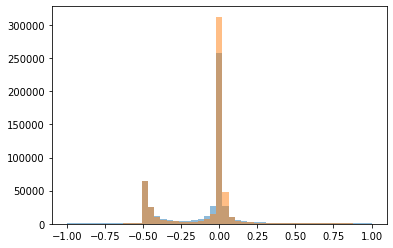

In [33]:
# overall pred vs input
bins = np.linspace(-1, 1, 50)
plt.hist(overall_input, bins=bins,alpha=0.5)
plt.hist(overall_pred, bins=bins,alpha=0.5)

(array([   866.,    915.,   1022.,   1017.,   1134.,   1202.,   1399.,
          1454.,   1666.,   1927.,   2228.,   2685.,   3478.,   8765.,
        253645.,  17829.,  11103.,   9528.,   8368.,  10685.,  15133.,
         67547.,  21766.,  11313.,   8119.,   5887.,   4746.,   3715.,
          3217.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

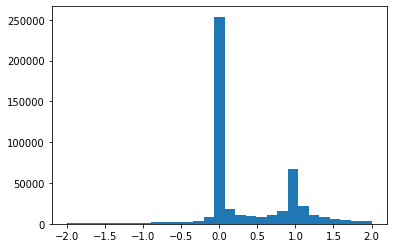

In [34]:
# overall distr
bins = np.linspace(-2, 2, 30)
plt.hist(overall_distr, bins=bins)

## Stacking output (orange) over input (blue) for px, py, pz, E

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.8555e+04,
        3.0885e+04, 1.0956e+04, 4.0240e+03, 1.8300e+03, 8.7100e+02,
        5.1600e+02, 9.4000e+01, 7.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([-0.2       , -0.18974359, -0.17948718, -0.16923077, -0.15897436,
        -0.14871795, -0.13846154, -0.12820513, -0.11794872, -0.10769231,
        -0.0974359 , -0.08717949, -0.07692308, -0.06666667, -0.05641026,
        -0.04615385, -0.03589744, -0.02564103, -0.01538462, -0.00512821,
         0.00512821,  0.01538462,  0.02564103,  0.03589744,  0.04615385,
         0.05641026,  0.06666667,  0.07692308,  0.08717949,  0.0974359 ,
         0.10769231,  0.1179

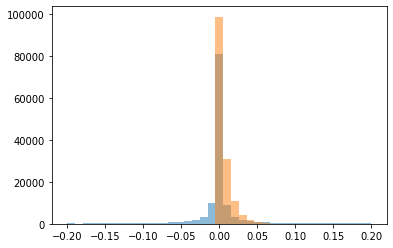

In [35]:
# px
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(px, bins=bins,alpha=0.5)
plt.hist(px_pred, bins=bins,alpha=0.5)

In [36]:
print(mse(px,px_pred))

tf.Tensor(1.0073242, shape=(), dtype=float32)


(array([0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 4.00000e+00, 7.00000e+00, 5.00000e+00, 1.80000e+01,
        1.60000e+01, 1.40000e+01, 2.90000e+01, 3.00000e+01, 5.40000e+01,
        5.70000e+01, 9.50000e+01, 9.00000e+01, 1.32000e+02, 1.58100e+03,
        1.10639e+05, 1.78620e+04, 6.20100e+03, 3.96200e+03, 2.69500e+03,
        1.66400e+03, 1.04800e+03, 6.44000e+02, 3.83000e+02, 2.44000e+02,
        1.33000e+02, 7.50000e+01, 3.70000e+01, 1.10000e+01, 5.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([-0.2       , -0.18974359, -0.17948718, -0.16923077, -0.15897436,
        -0.14871795, -0.13846154, -0.12820513, -0.11794872, -0.10769231,
        -0.0974359 , -0.08717949, -0.07692308, -0.06666667, -0.05641026,
        -0.04615385, -0.03589744, -0.02564103, -0.01538462, -0.00512821,
         0.00512821,  0.01538462,  0.02564103,  0.03589744,  0.04615385,
         0.05641026,  0.06666667,  0.07692308,  0.08717949,  0

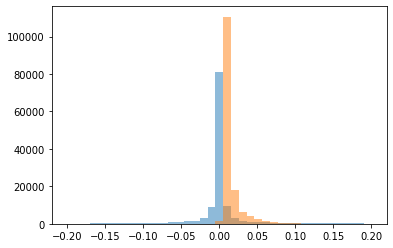

In [37]:
# py
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(py, bins=bins,alpha=0.5)
plt.hist(py_pred, bins=bins,alpha=0.5)

In [38]:
print(mse(py,py_pred))

tf.Tensor(0.990923, shape=(), dtype=float32)


(array([  362.,   379.,   403.,   462.,   503.,   528.,   529.,   586.,
          659.,   768.,   957.,  1111.,  1242.,  1367.,  1926.,  2722.,
         4146.,  6733., 12848., 40375., 14658.,  7247.,  4339.,  3159.,
         2274.,  1799.,  1239.,  1074.,   904.,   751.,   669.,   597.,
          560.,   516.,   514.,   420.,   385.,   371.,   344.]),
 array([-0.5       , -0.47435897, -0.44871795, -0.42307692, -0.3974359 ,
        -0.37179487, -0.34615385, -0.32051282, -0.29487179, -0.26923077,
        -0.24358974, -0.21794872, -0.19230769, -0.16666667, -0.14102564,
        -0.11538462, -0.08974359, -0.06410256, -0.03846154, -0.01282051,
         0.01282051,  0.03846154,  0.06410256,  0.08974359,  0.11538462,
         0.14102564,  0.16666667,  0.19230769,  0.21794872,  0.24358974,
         0.26923077,  0.29487179,  0.32051282,  0.34615385,  0.37179487,
         0.3974359 ,  0.42307692,  0.44871795,  0.47435897,  0.5       ]),
 <a list of 39 Patch objects>)

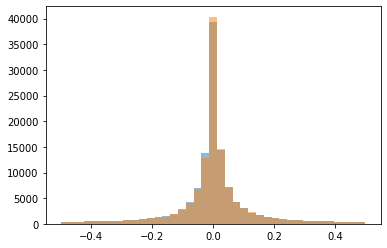

In [39]:
# pz
bins = np.linspace(-0.5, 0.5, 40)
plt.hist(pz, bins=bins,alpha=0.5)
plt.hist(pz_pred, bins=bins,alpha=0.5)

In [40]:
print(mse(pz,pz_pred))

tf.Tensor(1.1576655e-05, shape=(), dtype=float32)


(array([    0.,     0.,     0.,     0., 42532., 28388., 13158.,  7726.,
         5030.,  3615.,  2714.,  2347.,  1868.,  1447.,  1336.,  1053.,
         1002.,   932.,   800.,   691.,   676.,   636.,   549.,   493.,
          508.,   467.,   422.,   401.,   368.,   378.,   325.,   261.,
          306.,   272.,   262.,   243.,   248.,   240.,   221.]),
 array([-0.6       , -0.57692308, -0.55384615, -0.53076923, -0.50769231,
        -0.48461538, -0.46153846, -0.43846154, -0.41538462, -0.39230769,
        -0.36923077, -0.34615385, -0.32307692, -0.3       , -0.27692308,
        -0.25384615, -0.23076923, -0.20769231, -0.18461538, -0.16153846,
        -0.13846154, -0.11538462, -0.09230769, -0.06923077, -0.04615385,
        -0.02307692,  0.        ,  0.02307692,  0.04615385,  0.06923077,
         0.09230769,  0.11538462,  0.13846154,  0.16153846,  0.18461538,
         0.20769231,  0.23076923,  0.25384615,  0.27692308,  0.3       ]),
 <a list of 39 Patch objects>)

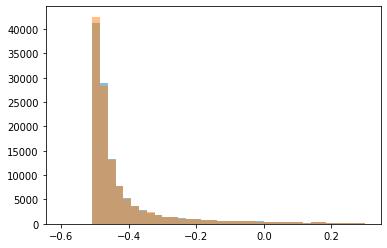

In [41]:
# E
bins = np.linspace(-0.6,0.3, 40)
plt.hist(e, bins=bins,alpha=0.5)
plt.hist(e_pred, bins=bins,alpha=0.5)

In [42]:
print(mse(e,e_pred))

tf.Tensor(5.4267266e-06, shape=(), dtype=float32)


In [43]:
d_px = [row[0] for row in distr]
d_py = [row[1] for row in distr]
d_pz = [row[2] for row in distr]
d_e = [row[3] for row in distr]

## Distribution of (input - output) / input

In [44]:
bins = np.linspace(-2, 2, 30)

(array([  199.,   227.,   257.,   268.,   335.,   398.,   447.,   511.,
          582.,   683.,   810.,   925.,  1168.,  1330.,  1829.,  2324.,
         2993.,  3865.,  5241.,  7424., 10958., 45082., 15876.,  8368.,
         5877.,  4138.,  3220.,  2449.,  2003.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

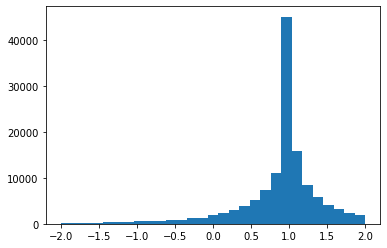

In [45]:
plt.hist(d_px, bins=bins)

(array([  594.,   600.,   649.,   627.,   653.,   632.,   731.,   705.,
          751.,   796.,   831.,   878.,   899.,   954.,  1043.,  1196.,
         1297.,  1464.,  1647.,  2211.,  3324., 21853.,  5444.,  2636.,
         1955.,  1561.,  1375.,  1155.,  1116.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

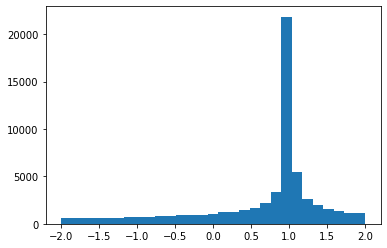

In [46]:
plt.hist(d_py, bins=bins)

(array([7.20000e+01, 8.60000e+01, 1.12000e+02, 1.20000e+02, 1.44000e+02,
        1.70000e+02, 2.18000e+02, 2.31000e+02, 3.28000e+02, 4.38000e+02,
        5.71000e+02, 8.47000e+02, 1.32600e+03, 6.06300e+03, 1.04191e+05,
        1.39390e+04, 6.75600e+03, 4.16900e+03, 1.46200e+03, 1.04100e+03,
        8.41000e+02, 6.05000e+02, 4.42000e+02, 3.06000e+02, 2.85000e+02,
        1.88000e+02, 1.49000e+02, 1.08000e+02, 9.60000e+01]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

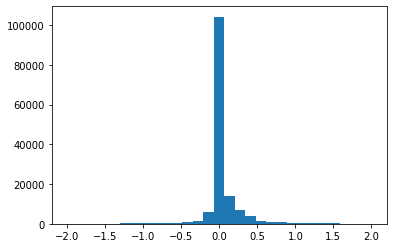

In [47]:
plt.hist(d_pz, bins=bins)

(array([1.00000e+00, 2.00000e+00, 4.00000e+00, 2.00000e+00, 2.00000e+00,
        2.00000e+00, 3.00000e+00, 7.00000e+00, 5.00000e+00, 1.00000e+01,
        1.60000e+01, 3.50000e+01, 8.50000e+01, 4.18000e+02, 1.46582e+05,
        3.70000e+02, 5.70000e+01, 3.00000e+01, 1.80000e+01, 9.00000e+00,
        1.00000e+01, 7.00000e+00, 4.00000e+00, 3.00000e+00, 2.00000e+00,
        0.00000e+00, 2.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

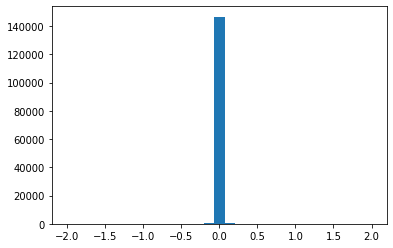

In [48]:
plt.hist(d_e, bins=bins)

# Anomaly Detection

In [49]:
from sklearn.metrics import mean_squared_error

In [50]:
all_data = np.concatenate((x_train, x_val, x_test))
all_pred = vae.predict(all_data)

In [51]:
# get the mse of all predictions
errors = (np.square(all_data - all_pred)).mean(axis=1)
mse_thresh = np.quantile(errors,0.95)

In [52]:
# all the inputs that had high mse
data_df = pd.DataFrame(loaded_data)
data_df.columns = ['px','py','pz','e','pt','eta','phi','mass']
data_df["mse"] = errors
data_df["outlier"] = 0

In [53]:
data_df.loc[data_df["mse"] > mse_thresh, "outlier"] = 1
data_df.loc[data_df["outlier"] == 1]

In [55]:
mass_mu = data_df.mass.mean()
mass_sd = data_df.mass.std()

In [56]:
# mass outliers from the whole dataset
big_set = data_df.loc[data_df["mass"] >= mass_mu + 5 * mass_sd]
# mass outliers from the outlier dataset
outlier_set = data_df.loc[data_df["outlier"] == 1].loc[data_df["mass"] >= mass_mu + 5 * mass_sd]

In [57]:
# proportion of jets with mass more than 5 std away
len(big_set) / len(data_df)

0.00898554393507936

In [58]:
# proportion of jets with mass more than 5 std away in the outlier data versus the total data: want this bigger
len(outlier_set) / len(big_set)

0.5373258003766478